In [299]:
import pandas as pd
import numpy as np
import seaborn as sb
import operator
from patsy import dmatrices

import matplotlib.pyplot as plt, matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

%matplotlib inline

### Load Data

In [300]:
train_data = pd.read_csv('./data/titanic/train.csv')
test_data = pd.read_csv('./data/titanic/test.csv')

### Check Data Content

In [301]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [302]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Pre-process Data

In [622]:
def age_approx(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):
        if Pclass == 1: return 37
        elif Pclass == 2: return 29
        else: return 20
    else:
        return Age

In [623]:
def embarked_convert(cols):
    embarked = cols[0]
    if embarked == 'C':
        return 0
    if embarked == 'Q':
        return 1
    if embarked == 'S':
        return 2
    return -1

In [635]:
def process_data(input_data):
    processed_data = input_data

    # Drop useless fields
    processed_data = processed_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], 1)

    # Convert 'Sex'(str) to 'Gender'(int), 0 for male and 1 for female
    processed_data['Gender'] = (processed_data.Sex == "female").astype(int)
    processed_data = processed_data.drop(['Sex'], 1)

    # Estimate missing 'Age' value by 'Fclass' value
    processed_data['Age'] = processed_data[['Age', 'Pclass', 'SibSp', 'Parch']].apply(age_approx, axis=1)

    # Convert 'Embarked'(str) to 'embark_location'(int)
    processed_data['embark_location'] = processed_data[['Embarked']].apply(embarked_convert, axis=1)
    processed_data = processed_data.drop(['Embarked'], 1)

    # Create new field 'Family_Size'
    processed_data['Family_Size'] = processed_data['SibSp'] + processed_data['Parch']
    processed_data = processed_data.drop(['SibSp', 'Parch'], 1)
    
    processed_data['Fare'] = (processed_data.Fare).fillna(0)
    return processed_data


In [636]:
processed_train_data = process_data(train_data)
processed_train_data.isnull().sum()
processed_train_data.head()

,Survived,Pclass,Age,Fare,Gender,embark_location,Family_Size
0,0,3,22.0,7.2500,0,2,1
1,1,1,38.0,71.2833,1,0,1
2,1,3,26.0,7.9250,1,2,0
3,1,1,35.0,53.1000,1,2,1
4,0,3,35.0,8.0500,0,2,0


### Check Processed Data

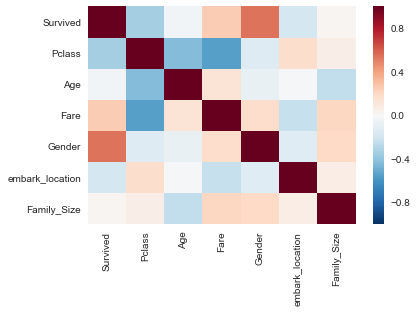

In [637]:
sb.heatmap(processed_train_data.corr())

In [627]:
processed_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 7 columns):
Survived           891 non-null int64
Pclass             891 non-null int64
Age                891 non-null float64
Fare               891 non-null float64
Gender             891 non-null int64
embark_location    891 non-null int64
Family_Size        891 non-null int64
dtypes: float64(2), int64(5)
memory usage: 48.8 KB


In [628]:
X = processed_train_data.iloc[:, 1:].values
y = processed_train_data.iloc[:, 0:1].values
y = np.ravel(y)

In [629]:
def get_model():
    weight = {0: 2, 1: 1.5}
    # instantiate a logistic regression model, and fit with X and y
    model = LogisticRegression()
    return model

In [630]:
def evaluate(X_train, X_test, y_train, y_test):
    model = get_model()
    model = model.fit(X_train, y_train)

    # check the accuracy on the training set
    print(model.score(X_test, y_test))

In [631]:
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
        evaluate(X[train_index], X[test_index], y[train_index], y[test_index])

0.781144781145
0.801346801347
0.801346801347


In [632]:
def test_performnace():
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)
    model = get_model()
    model = model.fit(X_train, y_train)

    # check the accuracy on the training set
    return model.score(X_test, y_test)

In [633]:
def evaluate():
    accuracy_array = []
    for i in range(20):
        accuracy_array.append(test_performnace())

    return sum(accuracy_array) / len(accuracy_array)

In [634]:
performance_array = []
for i in range (50):
    performance_array.append(evaluate())
print (sum(performance_array) / len(performance_array))

0.801944029851


In [602]:
model = get_model()
model = model.fit(X, y)

In [603]:
processed_test_data = process_data(test_data)
processed_test_data.isnull().sum()

Pclass             0
Age                0
Fare               0
Gender             0
embark_location    0
Family_Size        0
dtype: int64

In [604]:
# check the accuracy on the training set
y_pred = model.predict(processed_test_data)

### Utility Functions

In [605]:
import time
def get_timestamp():
    millis = int(round(time.time() * 1000))
    return millis

In [606]:
import csv
def save_prediction(y_pred):
    filename = 'titanic_prediction' + '_' + str(get_timestamp()) + '.csv'
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, delimiter=',')
        writer.writerow(['PassengerId', 'Survived'])
        for i in range (0, len(y_pred)):
            writer.writerow([str(test_data.PassengerId[i]), str(y_pred[i])])

In [607]:
save_prediction(y_pred)